In [1]:
!pip install xgboost
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score


from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier

In [2]:
df = pd.read_csv('Cleaned_Laptop_data.csv')
df.head()

,brand,model,processor_brand,processor_name,processor_gnrtn,ram_gb,ram_type,ssd,hdd,os,...,display_size,warranty,Touchscreen,msoffice,latest_price,old_price,discount,star_rating,ratings,reviews
0,Lenovo,A6-9225,AMD,A6-9225 Processor,10th,4 GB GB,DDR4,0 GB,1024 GB,Windows,...,Missing,0,No,No,24990,32790,23,3.7,63,12
1,Lenovo,Ideapad,AMD,APU Dual,10th,4 GB GB,DDR4,0 GB,512 GB,Windows,...,Missing,0,No,No,19590,21325,8,3.6,1894,256
2,Avita,PURA,AMD,APU Dual,10th,4 GB GB,DDR4,128 GB,0 GB,Windows,...,Missing,0,No,No,19990,27990,28,3.7,1153,159
3,Avita,PURA,AMD,APU Dual,10th,4 GB GB,DDR4,128 GB,0 GB,Windows,...,Missing,0,No,No,21490,27990,23,3.7,1153,159
4,Avita,PURA,AMD,APU Dual,10th,4 GB GB,DDR4,256 GB,0 GB,Windows,...,Missing,0,No,No,24990,33490,25,3.7,1657,234


In [3]:
df.nunique()

brand               21
model              117
processor_brand      5
processor_name      28
processor_gnrtn      8
ram_gb               4
ram_type             6
ssd                  8
hdd                  4
os                   3
os_bit               2
graphic_card_gb      5
weight               3
display_size        16
warranty             4
Touchscreen          2
msoffice             2
latest_price       429
old_price          564
discount            48
star_rating         30
ratings            310
reviews            152
dtype: int64

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 896 entries, 0 to 895
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   brand            896 non-null    object 
 1   model            896 non-null    object 
 2   processor_brand  896 non-null    object 
 3   processor_name   896 non-null    object 
 4   processor_gnrtn  896 non-null    object 
 5   ram_gb           896 non-null    object 
 6   ram_type         896 non-null    object 
 7   ssd              896 non-null    object 
 8   hdd              896 non-null    object 
 9   os               896 non-null    object 
 10  os_bit           896 non-null    object 
 11  graphic_card_gb  896 non-null    int64  
 12  weight           896 non-null    object 
 13  display_size     896 non-null    object 
 14  warranty         896 non-null    int64  
 15  Touchscreen      896 non-null    object 
 16  msoffice         896 non-null    object 
 17  latest_price    

In [5]:
import pandas as pd
import sqlite3


# 1. Add a Unique Identifier (row_id)
df['row_id'] = df.index + 1

# 2. Normalize Tables

# Brands Table
brands = df[['brand']].drop_duplicates().reset_index(drop=True)
brands['brand_id'] = brands.index + 1

# Models Table
models = df[['row_id', 'brand', 'model', 'processor_brand', 'processor_name', 'processor_gnrtn']].drop_duplicates()
models = models.merge(brands[['brand_id', 'brand']], on='brand', how='inner')
models['model_id'] = models.index + 1
models = models[['row_id', 'model_id', 'brand_id', 'model', 'processor_brand', 'processor_name', 'processor_gnrtn']]

# Specifications Table
specs = df[['row_id', 'ram_gb', 'ram_type', 'ssd', 'hdd', 'weight', 'display_size', 'warranty', 'Touchscreen', 'msoffice']].drop_duplicates()

# Prices Table
prices = df[['row_id', 'latest_price', 'old_price', 'discount']].drop_duplicates()

# Ratings & Reviews Table
reviews = df[['row_id', 'reviews', 'star_rating', 'ratings']].drop_duplicates()

# 3. Create SQLite Database
conn = sqlite3.connect("laptops_database.db")
cursor = conn.cursor()

# Drop tables if they already exist
drop_table_queries = [
    "DROP TABLE IF EXISTS Brands",
    "DROP TABLE IF EXISTS Models",
    "DROP TABLE IF EXISTS Specifications",
    "DROP TABLE IF EXISTS Prices",
    "DROP TABLE IF EXISTS Ratings_Reviews"
]
for query in drop_table_queries:
    cursor.execute(query)

# Create tables
create_table_queries = [
    """CREATE TABLE Brands (
        brand_id INTEGER PRIMARY KEY,
        brand TEXT
    )""",
    """CREATE TABLE Models (
        model_id INTEGER PRIMARY KEY,
        row_id INTEGER,
        brand_id INTEGER,
        model TEXT,
        processor_brand TEXT,
        processor_name TEXT,
        processor_gnrtn TEXT,
        FOREIGN KEY (brand_id) REFERENCES Brands(brand_id)
    )""",
    """CREATE TABLE Specifications (
        spec_id INTEGER PRIMARY KEY,
        row_id INTEGER,
        ram_gb TEXT,
        ram_type TEXT,
        ssd TEXT,
        hdd TEXT,
        weight TEXT,
        display_size TEXT,
        warranty INTEGER,
        Touchscreen TEXT,
        msoffice TEXT
    )""",
    """CREATE TABLE Prices (
        price_id INTEGER PRIMARY KEY,
        row_id INTEGER,
        latest_price INTEGER,
        old_price INTEGER,
        discount INTEGER
    )""",
    """CREATE TABLE Ratings_Reviews (
        rating_id INTEGER PRIMARY KEY,
        row_id INTEGER,
        reviews TEXT,
        star_rating REAL,
        ratings INTEGER
    )"""
]
for query in create_table_queries:
    cursor.execute(query)

# Commit table creation
conn.commit()

# 4. Insert Data into Tables
brands.to_sql("Brands", conn, if_exists="replace", index=False)
models.to_sql("Models", conn, if_exists="replace", index=False)
specs.to_sql("Specifications", conn, if_exists="replace", index=False)
prices.to_sql("Prices", conn, if_exists="replace", index=False)
reviews.to_sql("Ratings_Reviews", conn, if_exists="replace", index=False)

# Commit data insertion
conn.commit()


In [6]:

query = """
SELECT
    b.brand AS brand_name,
    m.model AS model_name,
    m.processor_brand,
    m.processor_name,
    m.processor_gnrtn,
    s.ram_gb,
    s.ram_type,
    s.ssd,
    s.hdd,
    s.weight,
    s.display_size,
    s.warranty,
    s.Touchscreen,
    s.msoffice,
    p.latest_price,
    p.old_price,
    p.discount,
    r.star_rating,
    r.ratings,
    r.reviews
FROM
    Models m
JOIN
    Brands b ON m.brand_id = b.brand_id
JOIN
    Specifications s ON m.row_id = s.row_id
JOIN 
    Prices p ON m.row_id = p.row_id
JOIN
    Ratings_Reviews r ON m.row_id = r.row_id;
"""

# Load data into a Pandas DataFrame
reconstructed_df = pd.read_sql_query(query, conn)

# Close the connection
conn.close()

# Display the reconstructed DataFrame
print(reconstructed_df.head())

# Optional: Save the reconstructed DataFrame to a CSV
reconstructed_df.to_csv("reconstructed_laptops.csv", index=False)


  brand_name model_name processor_brand     processor_name processor_gnrtn  \
0     Lenovo    A6-9225             AMD  A6-9225 Processor            10th   
1     Lenovo    Ideapad             AMD           APU Dual            10th   
2      Avita       PURA             AMD           APU Dual            10th   
3      Avita       PURA             AMD           APU Dual            10th   
4      Avita       PURA             AMD           APU Dual            10th   

    ram_gb ram_type     ssd      hdd      weight display_size  warranty  \
0  4 GB GB     DDR4    0 GB  1024 GB  ThinNlight      Missing         0   
1  4 GB GB     DDR4    0 GB   512 GB      Casual      Missing         0   
2  4 GB GB     DDR4  128 GB     0 GB  ThinNlight      Missing         0   
3  4 GB GB     DDR4  128 GB     0 GB  ThinNlight      Missing         0   
4  4 GB GB     DDR4  256 GB     0 GB  ThinNlight      Missing         0   

  Touchscreen msoffice  latest_price  old_price  discount  star_rating  \
0     

In [7]:
df = reconstructed_df
df.head()

,brand_name,model_name,processor_brand,processor_name,processor_gnrtn,ram_gb,ram_type,ssd,hdd,weight,display_size,warranty,Touchscreen,msoffice,latest_price,old_price,discount,star_rating,ratings,reviews
0,Lenovo,A6-9225,AMD,A6-9225 Processor,10th,4 GB GB,DDR4,0 GB,1024 GB,ThinNlight,Missing,0,No,No,24990,32790,23,3.7,63,12
1,Lenovo,Ideapad,AMD,APU Dual,10th,4 GB GB,DDR4,0 GB,512 GB,Casual,Missing,0,No,No,19590,21325,8,3.6,1894,256
2,Avita,PURA,AMD,APU Dual,10th,4 GB GB,DDR4,128 GB,0 GB,ThinNlight,Missing,0,No,No,19990,27990,28,3.7,1153,159
3,Avita,PURA,AMD,APU Dual,10th,4 GB GB,DDR4,128 GB,0 GB,ThinNlight,Missing,0,No,No,21490,27990,23,3.7,1153,159
4,Avita,PURA,AMD,APU Dual,10th,4 GB GB,DDR4,256 GB,0 GB,ThinNlight,Missing,0,No,No,24990,33490,25,3.7,1657,234


In [8]:

price_min = df['latest_price'].min()
price_max = df['latest_price'].max()
price_mean = df['latest_price'].mean()
price_median = df['latest_price'].median()
price_percentiles = df['latest_price'].quantile([0.25, 0.5, 0.75])  # 25th, 50th, 75th percentiles

print(f"Minimum Price: {price_min}")
print(f"Maximum Price: {price_max}")
print(f"Mean Price: {price_mean}")
print(f"Median Price: {price_median}")
print(f"25th Percentile: {price_percentiles[0.25]}")
print(f"50th Percentile (Median): {price_percentiles[0.5]}")
print(f"75th Percentile: {price_percentiles[0.75]}")

# 2. Suggest Dynamic Bins for Classification
bins = [price_min, price_percentiles[0.25], price_percentiles[0.75], price_max]
labels = ['Low', 'Mid', 'High']  # Dynamic categories
print(f"Suggested Bins: {bins}")

Minimum Price: 13990
Maximum Price: 441990
Mean Price: 76309.86049107143
Median Price: 63494.0
25th Percentile: 45490.0
50th Percentile (Median): 63494.0
75th Percentile: 89090.0
Suggested Bins: [13990, 45490.0, 89090.0, 441990]


In [9]:
df['price_category'] = pd.cut(
    df['latest_price'],
    bins=bins,
    labels=labels,
    include_lowest=True
)

print(df['price_category'].value_counts())

price_category
Mid     446
Low     226
High    224
Name: count, dtype: int64


In [10]:
df.drop(['latest_price', 'old_price', 'discount'], axis=1, inplace = True)

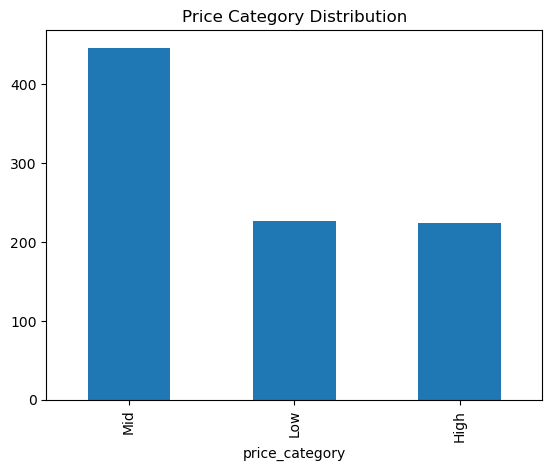

In [11]:
df['price_category'].value_counts().plot(kind='bar', title='Price Category Distribution')
plt.show()

In [12]:

bucket_mapping = {'Low': 0, 'Mid': 1, 'High': 2}

# Apply the mapping to the target column
df['price_category'] = df['price_category'].map(bucket_mapping)

# Verify the conversion
print(df['price_category'].head())


0    0
1    0
2    0
3    0
4    0
Name: price_category, dtype: category
Categories (3, int64): [0 < 1 < 2]


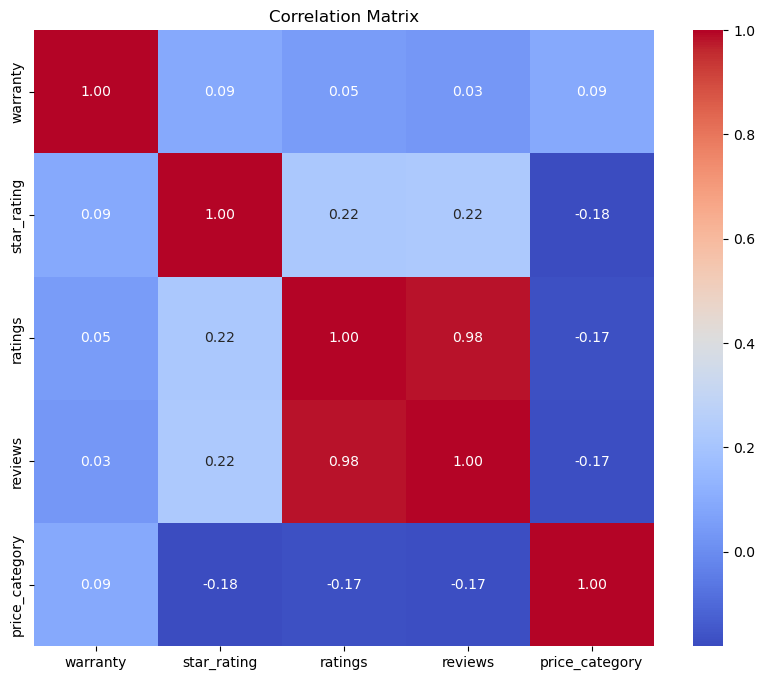

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

# Keep only numeric columns
numeric_df = df.select_dtypes(include=['float64', 'int64', 'category'])

# Correlation Matrix
correlation_matrix = numeric_df.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix")
plt.show()


In [14]:
!pip install category_encoders

In [15]:
!pip install mlflow

In [17]:
import dagshub
dagshub.init(repo_owner='nannayashu08', repo_name='price_detection', mlflow=True)

Accessing as nannayashu08

Initialized MLflow to track repo "nannayashu08/price_detection"

Repository nannayashu08/price_detection initialized!

In [18]:
import mlflow

mlflow.set_tracking_uri("https://dagshub.com/nannayashu08/price_detection.mlflow")

In [32]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier

# Define numerical and categorical columns
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns
categorical_columns = df.select_dtypes(include=['object']).columns

# Numerical Transformer
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Handle missing values
    ('scaler', StandardScaler())                   # Scale numerical features
])

# Categorical Transformer
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Handle missing values
    ('onehot', OneHotEncoder(handle_unknown='ignore'))     # Encode categorical features
])

# ColumnTransformer for Preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_columns),
        ('cat', categorical_transformer, categorical_columns)
    ]
)


logistic_model = LogisticRegression(max_iter=1000, random_state=42)
ridge_model = RidgeClassifier(random_state=42)
random_model = RandomForestClassifier(random_state=42),
xgb_model = XGBClassifier(
    max_depth=6,
    learning_rate=0.1,
    n_estimators=100,
    colsample_bytree=0.8,
    subsample=0.8,
    random_state=42
)

# Pipeline with Preprocessor and Model
pipeline_logistic = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', logistic_model)
])

# Train/Test Split
X = df.drop(columns=['price_category'])  # Replace 'price_category' with your target column
y = df['price_category']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Fit the Pipeline
pipeline_logistic.fit(X_train, y_train)

# Evaluate the Model
train_score = pipeline_logistic.score(X_train, y_train)
test_score = pipeline_logistic.score(X_test, y_test)

print(f"Train Accuracy: {train_score:.2f}")
print(f"Test Accuracy: {test_score:.2f}")

NotFittedError: This ColumnTransformer instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [19]:
# Update the scoring to handle multiclass targets
from sklearn.metrics import make_scorer

# Define f1_scorer with 'weighted' average for multiclass
f1_scorer = make_scorer(f1_score, average='weighted')

# GridSearchCV with updated scorer
grid_search = GridSearchCV(
    pipeline_logistic, param_grid,
    cv=StratifiedKFold(n_splits=10),
    scoring=f1_scorer, verbose=2, n_jobs=-1, return_train_score=True
)
mlflow.set_experiment("Experiment 1")
with mlflow.start_run():
    # Fit GridSearchCV
    grid_search.fit(X_train, y_train)

    # Log Best Estimator and Parameters
    best_pipeline = grid_search.best_estimator_
    best_params = grid_search.best_params_
    print("Best Params:", best_params)
    mlflow.log_params(best_params)

    # Cross-Validation Results
    cv_results = cross_validate(
        best_pipeline, X_train, y_train, cv=10,
        scoring=f1_scorer, return_train_score=True
    )
    mean_f1 = np.mean(cv_results['test_score'])
    std_f1 = np.std(cv_results['test_score'])

    mlflow.log_metric("mean_f1_cv", mean_f1)
    mlflow.log_metric("std_f1_cv", std_f1)

    # Fit Best Pipeline on Training Data
    best_pipeline.fit(X_train, y_train)

    # Evaluate on Train Data
    y_pred_train = best_pipeline.predict(X_train)
    train_f1 = f1_score(y_train, y_pred_train, average='weighted')  # Ensure 'weighted' average
    train_cm = confusion_matrix(y_train, y_pred_train).ravel()
    mlflow.log_metric("train_f1", train_f1)
    mlflow.log_text(f"Train Confusion Matrix: {train_cm}", "confusion_matrix/train_confusion_matrix.txt")

    # Evaluate on Test Data
    y_pred_test = best_pipeline.predict(X_test)
    test_f1 = f1_score(y_test, y_pred_test, average='weighted')  # Ensure 'weighted' average
    test_cm = confusion_matrix(y_test, y_pred_test).ravel()
    mlflow.log_metric("test_f1", test_f1)
    mlflow.log_text(f"Test Confusion Matrix: {test_cm}", "confusion_matrix/test_confusion_matrix.txt")

    # Save Model to MLflow
    mlflow.sklearn.log_model(best_pipeline, "logistic_regression_pipeline")

NameError: name 'pipeline_logistic' is not defined

In [ ]:

pipeline_logistic = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

pipeline_logistic.fit(X, y)

pipeline_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Preprocessing step
    ('classifier', XGBClassifier(random_state=42, n_jobs=-1))  # Single model
])

pipeline_xgb.fit(X, y)


In [ ]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, FunctionTransformer
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import f1_score, confusion_matrix, make_scorer
import mlflow
import mlflow.sklearn

# Define Log Transformation Function
def log_transform(x):
    return np.log1p(np.maximum(x, 0))

# Separate Numerical and Categorical Columns
numerical_columns = X.select_dtypes(include=['int64', 'float64']).columns
categorical_columns = X.select_dtypes(include=['object']).columns

# Numerical Feature Preprocessing Pipeline
numerical_transformer = Pipeline(steps=[
    ('log', FunctionTransformer(log_transform)),
    ('scaler', StandardScaler()),
    ('minmax', MinMaxScaler())
])

# Categorical Feature Preprocessing Pipeline
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine Preprocessors into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_columns),
        ('cat', categorical_transformer, categorical_columns)
    ]
)

# Define Classifiers
classifiers = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'RidgeClassifier': RidgeClassifier(random_state=42),
    'RandomForestClassifier': RandomForestClassifier(random_state=42),
    'XGBClassifier': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Set MLflow Tracking URI and Experiment
mlflow.set_tracking_uri("https://dagshub.com/nannayashu08/Lap.mlflow")
mlflow.set_experiment("Experiment 2")

for name, model in classifiers.items():
    with mlflow.start_run(run_name=name):
        # Create Pipeline
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', model)
        ])

        # Define Hyperparameter Grid
        if name == 'LogisticRegression':
            param_grid = {
                'classifier__C': [0.01, 0.1, 1, 10],
                'classifier__penalty': ['l2'],
                'classifier__solver': ['lbfgs', 'liblinear']
            }
        elif name == 'RidgeClassifier':
            param_grid = {
                'classifier__alpha': [0.01, 0.1, 1, 10]
            }
        elif name == 'RandomForestClassifier':
            param_grid = {
                'classifier__n_estimators': [100, 200, 300],
                'classifier__max_depth': [None, 10, 20]
            }
        elif name == 'XGBClassifier':
            param_grid = {
                'classifier__n_estimators': [100, 200, 300],
                'classifier__learning_rate': [0.01, 0.1, 0.2],
                'classifier__max_depth': [3, 6, 10]
            }

        # GridSearchCV with StratifiedKFold
        grid_search = GridSearchCV(
            pipeline, param_grid,
            cv=StratifiedKFold(n_splits=10),
            scoring='f1_weighted', verbose=2, n_jobs=-1, return_train_score=True
        )

        # Fit GridSearchCV
        grid_search.fit(X_train, y_train)

        # Log Best Estimator and Parameters
        best_pipeline = grid_search.best_estimator_
        best_params = grid_search.best_params_
        print(f"{name} - Best Params:", best_params)
        mlflow.log_params(best_params)

        # Cross-Validation Results
        cv_results = cross_validate(
            best_pipeline, X_train, y_train, cv=10,
            scoring='f1_weighted', return_train_score=True
        )
        mean_f1 = np.mean(cv_results['test_score'])
        std_f1 = np.std(cv_results['test_score'])

        mlflow.log_metric("mean_f1_cv", mean_f1)
        mlflow.log_metric("std_f1_cv", std_f1)

        # Fit Best Pipeline on Training Data
        best_pipeline.fit(X_train, y_train)

        # Evaluate on Train Data
        y_pred_train = best_pipeline.predict(X_train)
        train_f1 = f1_score(y_train, y_pred_train, average='weighted')
        train_cm = confusion_matrix(y_train, y_pred_train).ravel()
        mlflow.log_metric("train_f1", train_f1)
        mlflow.log_text(f"Train Confusion Matrix: {train_cm}", f"confusion_matrix/{name}_train_confusion_matrix.txt")

        # Evaluate on Test Data
        y_pred_test = best_pipeline.predict(X_test)
        test_f1 = f1_score(y_test, y_pred_test, average='weighted')
        test_cm = confusion_matrix(y_test, y_pred_test).ravel()
        mlflow.log_metric("test_f1", test_f1)
        mlflow.log_text(f"Test Confusion Matrix: {test_cm}", f"confusion_matrix/{name}_test_confusion_matrix.txt")

        # Save Model to MLflow
        mlflow.sklearn.log_model(best_pipeline, f"{name}_pipeline")

print("Experiment 2 execution and tracking complete.")


In [ ]:
X

In [ ]:

def feature_engineering(data):
    # Clean and transform 'weight' column (convert to numeric)
    data['weight'] = data['weight'].str.replace('kg', '').astype(float)
    
    # Create derived features
    data['price_difference'] = data['old_price'] - data['latest_price']
    data['discounted_price_ratio'] = data['latest_price'] / data['old_price']
    data['graphics_to_price_ratio'] = data['graphic_card_gb'] / data['latest_price']
    
    return data

# Separate Numerical and Categorical Columns
numerical_columns = [
    'graphic_card_gb', 'latest_price', 'old_price', 'discount', 'star_rating',
    'ratings', 'reviews', 'weight', 'price_difference', 'discounted_price_ratio', 'graphics_to_price_ratio'
]
categorical_columns = [
    'brand', 'model', 'processor_brand', 'processor_name', 'processor_gnrtn', 'ram_gb',
    'ram_type', 'ssd', 'hdd', 'os', 'os_bit', 'Touchscreen', 'msoffice'
]


# Separate Numerical and Categorical Columns
numerical_columns = X.select_dtypes(include=['int64', 'float64']).columns
categorical_columns = X.select_dtypes(include=['object']).columns

# Numerical Feature Preprocessing Pipeline
numerical_transformer = Pipeline(steps=[
    ('log', FunctionTransformer(log_transform)),
    ('scaler', StandardScaler()),
    ('minmax', MinMaxScaler())
])

# Categorical Feature Preprocessing Pipeline
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine Preprocessors into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_columns),
        ('cat', categorical_transformer, categorical_columns)
    ]
)

# Define Classifiers
classifiers = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'RidgeClassifier': RidgeClassifier(random_state=42),
    'RandomForestClassifier': RandomForestClassifier(random_state=42),
    'XGBClassifier': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Apply Feature Engineering
X_train = feature_engineering(X_train)
X_test = feature_engineering(X_test)

# Set MLflow Tracking URI and Experiment
mlflow.set_tracking_uri("https://dagshub.com/nannayashu08/Lap.mlflow")  # Replace with your DagsHub repo details
mlflow.set_experiment("Experiment 3")

for name, model in classifiers.items():
    with mlflow.start_run(run_name=name):
        # Create Pipeline
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', model)
        ])

        # Define Hyperparameter Grid
        if name == 'LogisticRegression':
            param_grid = {
                'classifier__C': [0.01, 0.1, 1, 10],
                'classifier__penalty': ['l2'],
                'classifier__solver': ['lbfgs', 'liblinear']
            }
        elif name == 'RidgeClassifier':
            param_grid = {
                'classifier__alpha': [0.01, 0.1, 1, 10]
            }
        elif name == 'RandomForestClassifier':
            param_grid = {
                'classifier__n_estimators': [100, 200, 300],
                'classifier__max_depth': [None, 10, 20]
            }
        elif name == 'XGBClassifier':
            param_grid = {
                'classifier__n_estimators': [100, 200, 300],
                'classifier__learning_rate': [0.01, 0.1, 0.2],
                'classifier__max_depth': [3, 6, 10]
            }

        # GridSearchCV with StratifiedKFold
        grid_search = GridSearchCV(
            pipeline, param_grid,
            cv=StratifiedKFold(n_splits=10),
            scoring='f1_weighted', verbose=2, n_jobs=-1, return_train_score=True
        )

        # Fit GridSearchCV
        grid_search.fit(X_train, y_train)

        # Log Best Estimator and Parameters
        best_pipeline = grid_search.best_estimator_
        best_params = grid_search.best_params_
        print(f"{name} - Best Params:", best_params)
        mlflow.log_params(best_params)

        # Cross-Validation Results
        cv_results = cross_validate(
            best_pipeline, X_train, y_train, cv=10,
            scoring='f1_weighted', return_train_score=True
        )
        mean_f1 = np.mean(cv_results['test_score'])
        std_f1 = np.std(cv_results['test_score'])

        mlflow.log_metric("mean_f1_cv", mean_f1)
        mlflow.log_metric("std_f1_cv", std_f1)

        # Fit Best Pipeline on Training Data
        best_pipeline.fit(X_train, y_train)

        # Evaluate on Train Data
        y_pred_train = best_pipeline.predict(X_train)
        train_f1 = f1_score(y_train, y_pred_train, average='weighted')
        train_cm = confusion_matrix(y_train, y_pred_train).ravel()
        mlflow.log_metric("train_f1", train_f1)
        mlflow.log_text(f"Train Confusion Matrix: {train_cm}", f"confusion_matrix/{name}_train_confusion_matrix.txt")

        # Evaluate on Test Data
        y_pred_test = best_pipeline.predict(X_test)
        test_f1 = f1_score(y_test, y_pred_test, average='weighted')
        test_cm = confusion_matrix(y_test, y_pred_test).ravel()
        mlflow.log_metric("test_f1", test_f1)
        mlflow.log_text(f"Test Confusion Matrix: {test_cm}", f"confusion_matrix/{name}_test_confusion_matrix.txt")

        # Save Model to MLflow
        mlflow.sklearn.log_model(best_pipeline, f"{name}_pipeline")

print("Experiment 3 execution and tracking complete.")


In [ ]:
# Upload using the DagsHub client, to a DVC tracked folder also called "data".
# Follow the instructions that appear to authorize the request.
from dagshub import upload_files
upload_files('nannayashu08/price_detection', 'Cleaned_Laptop_data.csv')